In [1]:
from functools import wraps
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

%matplotlib inline
jtplot.style()

device = torch.device('cuda')

In [2]:
class FullyConnectedGNNLayer(nn.Module):
    def __init__(self, n_nodes, in_features, out_features, activation_func=nn.ReLU(), squeeze_out=False):
        super().__init__()
        self.n_nodes = n_nodes
        self.activation_func = activation_func
        self.transform_features = nn.Linear(in_features, out_features)
        self.message_passing_mat = nn.Parameter(
            (torch.ones((n_nodes, n_nodes)) - torch.eye(n_nodes)) / (n_nodes - 1),
            requires_grad=False
        )
        self.recombine_features = nn.Linear(out_features*2, out_features)
        self.squeeze_out = squeeze_out
    
    def forward(self, features):
        features_transformed = self.activation_func(
            self.transform_features(features)
        )
        messages = torch.matmul(self.message_passing_mat, features_transformed)
        features_messages_combined = self.activation_func(
            self.recombine_features(torch.cat([features_transformed, messages], dim=-1))
        )
        if self.squeeze_out:
            return features_messages_combined.squeeze(dim=-1)
        else:
            return features_messages_combined

In [14]:
END_OF_GAME = 0
EVERY_STEP = 1
class Kaggle_MAB_Env_Torch_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False, env_device=torch.device('cpu'), out_device=torch.device('cpu')):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        self.env_device = env_device
        self.out_device = out_device
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
        
    def _out_device_decorator(f):
        @wraps(f)
        def wrapped(self, *args, **kwargs):
            return [out.to(self.out_device) if torch.is_tensor(out) else out for out in f(self, *args, **kwargs)]
        return wrapped
    
    @_out_device_decorator
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = torch.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits), dtype=torch.float32, device=self.env_device)
        self.player_n_pulls = torch.zeros((self.n_envs, self.n_players, self.n_bandits), device=self.env_device)
        self.player_rewards_sums = torch.zeros_like(self.player_n_pulls)
        
        rewards = torch.zeros((self.n_envs, self.n_players), device=self.env_device)
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    @_out_device_decorator
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = torch.tensor([[actions]], device=self.env_device)
            else:
                actions = actions.view((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        actions = actions.to(self.env_device)
        
        # Compute agent rewards
        selected_thresholds = self.thresholds.gather(-1, actions)
        pull_rewards = torch.randint(self.sample_resolution, size=selected_thresholds.shape, dtype=torch.float32, device=self.env_device) < selected_thresholds
        #pull_rewards = selected_thresholds / self.sample_resolution
        
        # Update player_n_pulls and player_rewards_sums
        #for env_idx, env_actions in enumerate(actions):
        #    for player_idx, pull_idx in enumerate(env_actions):
        #        self.player_n_pulls[env_idx, :, pull_idx] += 1
        #        self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        actions_expanded = actions.unsqueeze(1).expand(-1, self.n_players, -1)
        self.player_n_pulls.scatter_(
            -1,
            actions_expanded,
            self.player_n_pulls.gather(-1, actions_expanded) + 1
        )
        self.player_rewards_sums[
            torch.arange(self.n_envs).repeat_interleave(self.n_players),
            torch.arange(self.n_players).repeat(self.n_envs),
            actions.view(-1)
        ] += pull_rewards.view(-1)
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = torch.zeros_like(actions).float()
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(dim=2)
                winners = rewards_sums.argmax(dim=1)
                rewards[winners] = 1.
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        return torch.stack([
            self.player_n_pulls,
            self.player_rewards_sums
        ], dim=-1)
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [24]:
class GraphNN_A3C(nn.Module):
    def __init__(self, in_features, n_nodes):
        super().__init__()
        # Define network
        activation_func = nn.Identity()
        layer_size = 32
        layers = (
            [FullyConnectedGNNLayer(n_nodes, in_features, layer_size, activation_func=activation_func)] +
            [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0
        )
        self.base = nn.Sequential(*layers)
        self.actor = FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func, squeeze_out=True)
        self.critic = FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=nn.Identity(), squeeze_out=True)
        
        self.train()
    
    def forward(self, states):
        base_out = self.base(states)
        return self.actor(base_out), self.critic(base_out).mean(dim=-1)
    
    def choose_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss


def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=device)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.choose_action(s.to(device=device).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=device).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=device)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=device),
                    torch.stack(buffer_a).to(device=device),
                    torch.stack(buffer_v_target).to(device=device)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
    return [rs.mean() for rs in episode_reward_sums]

In [25]:
env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=256, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=device)
model = GraphNN_A3C(2, env.n_bandits)
model.to(device=device)
optimizer = torch.optim.Adam(model.parameters())
episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=20, batch_size=60, gamma=0.99)

100%|██████████| 20/20 [01:25<00:00,  4.25s/it]


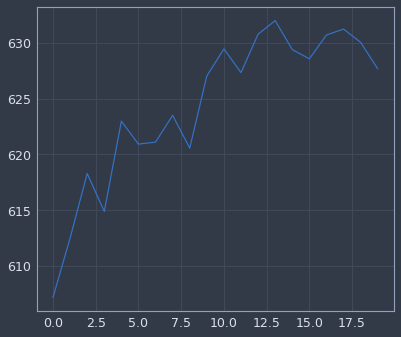

In [26]:
#rewards = reinforce(env, policy_est, batch_size=2, num_episodes=100)
plt.plot(episode_reward_sums);

#### TODO:
Write agent file allowing me to play trained agents against other hand-written agent submissions

Adjust size of GNN - add more layers

Tune gamma and/or batch_size

Eventually, experiment with reward_type = END_OF_GAME

In [18]:
episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=50, batch_size=30, gamma=0.99)

100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


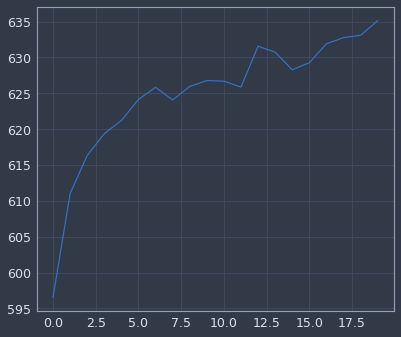

In [6]:
#rewards = reinforce(env, policy_est, batch_size=2, num_episodes=100)
plt.plot(episode_reward_sums);

## Testing and debugging

In [12]:
test_env = Kaggle_MAB_Env_Torch_Vectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=device)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)

test_env.player_rewards_sums

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [63]:
from scipy.stats import spearmanr, pearsonr

test_env = Kaggle_MAB_Env_Vectorized(n_players=1, remove_extra_dims=True, decay_rate=1.)
policy_est = GraphNN(3, 1)
rewards = reinforce(env, policy_est, batch_size=1, n_episodes=10)
with torch.no_grad():
    s, _, _, _ = test_env.reset()
    pred = policy_est(torch.from_numpy(s).to(device=device)).cpu().numpy()
print()
print(pred)
print(s[:,0])
print(spearmanr(pred, s[:,0])[0], pearsonr(pred, s[:,0])[0])

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[0.01002364 0.00997299 0.00998578 0.01002303 0.01000408 0.01000531
 0.01001141 0.00996934 0.00999554 0.00999188 0.00999371 0.00999981
 0.01003099 0.01002976 0.00998456 0.01000225 0.00999554 0.00998944
 0.01001264 0.00997117 0.01001997 0.00999981 0.01000164 0.00997847
 0.0099992  0.01002915 0.00997299 0.00999798 0.00999981 0.00997117
 0.00999737 0.01003099 0.00998456 0.00996934 0.00997786 0.01002915
 0.01002793 0.00998091 0.00997238 0.01000958 0.01002609 0.01001569
 0.00998578 0.01001019 0.00997969 0.00999554 0.00997482 0.00997786
 0.01002854 0.01000347 0.00998822 0.01002425 0.01002854 0.00999371
 0.00999432 0.01001692 0.01002242 0.01002425 0.00998091 0.01000469
 0.01001141 0.00998517 0.01002548 0.009987   0.01001814 0.01001325
 0.01002425 0.01000836 0.0099992  0.00998822 0.00999066 0.0099803
 0.01001447 0.01000469 0.01001203 0.00997604 0.01001508 0.00997117
 0.00998761 0.01003037 0.00996995 0.01000653 0.00997665 0.00997847
 0.00996934 0.00999188 0.01002609 0.01002915 0.01003099 0.0099

In [42]:
test_env = Kaggle_MAB_Env_Vectorized(n_envs=500, n_players=1, decay_rate=1.)

for i in tqdm.trange(test_env.n_steps):
    actions = np.random.randint(100, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
test_env.player_rewards_sums.sum(axis=-1).mean(), test_env.player_rewards_sums.sum(axis=-1).std()

100%|██████████| 1999/1999 [00:11<00:00, 172.19it/s]


(1005.06, 61.294342316399806)

In [32]:
test_env = Kaggle_MAB_Env_Vectorized(n_envs=250, n_players=2, decay_rate=0.97)

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(np.broadcast_to(actions, (test_env.n_envs, test_env.n_players)))
test_env.player_rewards_sums.sum(axis=-1).mean(), test_env.player_rewards_sums.sum(axis=-1).std()

100%|██████████| 1999/1999 [00:08<00:00, 247.70it/s]


(653.577215086164, 33.41196941037249)

In [152]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

100%|██████████| 10/10 [00:00<00:00, 479.15it/s]

Loss: 2.30, Accuracy: 0.000
tensor([[[0.8214],
         [0.5663],
         [0.7303],
         [0.6139],
         [0.0942],
         [0.2026],
         [0.8251],
         [0.3299],
         [0.0296],
         [0.5319]]], device='cuda:0')
tensor([[[0.1007],
         [0.1003],
         [0.1006],
         [0.1004],
         [0.0990],
         [0.0994],
         [0.1007],
         [0.0997],
         [0.0988],
         [0.1003]]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0]], device='cuda:0')
tensor([[6]], device='cuda:0')


In [153]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

100%|██████████| 1000/1000 [00:01<00:00, 549.97it/s]

Loss: 2.29, Accuracy: 0.000


In [250]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

100%|██████████| 10000/10000 [00:08<00:00, 1172.83it/s]


tensor(2.2476e-11, device='cuda:0', grad_fn=<MseLossBackward>)

In [251]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

tensor([[[0.8142],
         [0.2351],
         [0.0057],
         [0.8548],
         [0.5895]],

        [[0.9160],
         [0.7284],
         [0.4671],
         [0.4535],
         [0.1266]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5050],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5051],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0', grad_fn=<AddBackward0>)


In [118]:
child_idx = -1
print(list(model.children())[child_idx].transform_features.weight.data, list(model.children())[child_idx].transform_features.bias.data)
print(list(model.children())[child_idx].recombine_features.weight.data, list(model.children())[child_idx].recombine_features.bias.data)
#model.message_passing_mat

tensor([[-0.0268, -0.0445,  0.0814,  0.0578, -0.0223, -0.0030, -0.0113,  0.0988,
         -0.1126,  0.0250, -0.1195,  0.0792, -0.1035,  0.0792,  0.1039, -0.0649,
          0.0926,  0.0105, -0.1005,  0.0191, -0.0927,  0.0873, -0.0442, -0.0873,
         -0.0545,  0.0852,  0.0263, -0.0080, -0.0911, -0.0923, -0.1211,  0.1100,
         -0.0782,  0.0099, -0.0972, -0.0283,  0.0352,  0.1225,  0.0202, -0.0982,
          0.0804, -0.1218, -0.0615, -0.0282, -0.0387,  0.1030,  0.0157, -0.0376,
         -0.0027, -0.0425, -0.0577,  0.0745,  0.0306, -0.0299,  0.0535,  0.0026,
          0.0562,  0.1197, -0.0381,  0.0243, -0.0914, -0.1078, -0.0665, -0.0355]],
       device='cuda:0') tensor([0.0346], device='cuda:0')
tensor([[ 0.0029, -0.2631]], device='cuda:0') tensor([0.1936], device='cuda:0')


## Deprecated

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps